In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd '/content/gdrive/MyDrive/data_challenge/datasets_train/'

Mounted at /content/gdrive
/content/gdrive/MyDrive/data_challenge/datasets_train


In [117]:
import pandas as pd
df = pd.read_csv('train_annotation/_annotation.csv')
df = df[df['class']==1]
df = df.dropna()
df = df.reset_index(drop=True)
df.head()


,im_name,x_min,y_min,x_max,y_max,class,models
0,1000407040.jpg,7.0,26.0,392.0,225.0,1,Toyota Sequoia SUV 2012
1,1000472576.jpg,27.0,62.0,519.0,298.0,1,Toyota Sequoia SUV 2012
2,1000669184.jpg,6.0,62.0,499.0,286.0,1,Toyota Sequoia SUV 2012
3,1000800256.jpg,68.0,16.0,450.0,222.0,1,Toyota Sequoia SUV 2012
4,1001324544.jpg,33.0,56.0,408.0,294.0,1,Toyota Sequoia SUV 2012


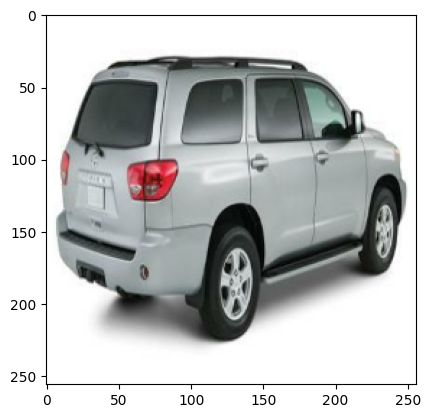

In [122]:
import matplotlib.pyplot as plt
import tensorflow as tf
folder_images = 'train/'
target_size = (256, 256)

def load_image(filepath, resize=target_size):
    im = tf.io.read_file(folder_images + filepath)
    im = tf.image.decode_png(im, channels=3)
    if resize:
        return tf.image.resize(im, resize)
    else :
        return im


im = load_image(df.im_name[0], resize=target_size)
plt.imshow(im/255);


In [119]:
df['xmoy'] = (df.x_max + df.x_min)/2
df['ymoy'] = (df.y_max + df.y_min)/2
df['w'] = (df.x_max - df.x_min)
df['h'] = (df.y_max - df.y_min)

for i in range(len(df)):
  im = tf.io.read_file(folder_images + df['im_name'][i])
  im = tf.image.decode_png(im, channels=3)
  df.loc[i, 'xmoy'] = df['xmoy'][i]*256/im.shape[1]
  df.loc[i, 'ymoy'] = df['ymoy'][i]*256/im.shape[0]
  df.loc[i, 'w'] = df['w'][i]*256/im.shape[1]
  df.loc[i, 'h'] = df['h'][i]*256/im.shape[0]

df.head()


,im_name,x_min,y_min,x_max,y_max,class,models,xmoy,ymoy,w,h
0,1000407040.jpg,7.0,26.0,392.0,225.0,1,Toyota Sequoia SUV 2012,127.680000,128.512000,246.400000,203.776000
1,1000472576.jpg,27.0,62.0,519.0,298.0,1,Toyota Sequoia SUV 2012,121.544348,142.222222,219.046957,186.469136
2,1000669184.jpg,6.0,62.0,499.0,286.0,1,Toyota Sequoia SUV 2012,129.280000,141.409524,252.416000,182.044444
3,1000800256.jpg,68.0,16.0,450.0,222.0,1,Toyota Sequoia SUV 2012,132.608000,129.084746,195.584000,223.457627
4,1001324544.jpg,33.0,56.0,408.0,294.0,1,Toyota Sequoia SUV 2012,117.600000,124.444444,200.000000,169.244444


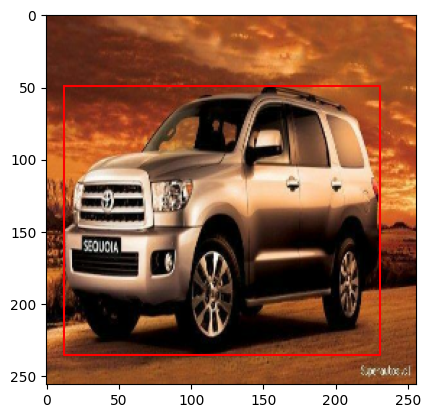

In [121]:
import numpy as np

def show_bounding_box(im, bbox, normalised=False, color='r'):
    # Signification de bbox
    x, y, w, h = bbox
    # Convertir les cordonées (x,y,w,h) en (x1,x2,y1,y2)
    x1=x-w/2
    x2=x+w/2
    y1=y-h/2
    y2=y+h/2

    # Redimensionner en cas de normalisation
    if normalised:
        x1=x1*im.shape[1]
        x2=x2*im.shape[1]
        y1=y1*im.shape[0]
        y2=y2*im.shape[0]

    # Afficher l'image
    plt.imshow(im/255)

    # Afficher la bounding box
    plt.plot([x1,x2,x2,x1,x1],[y1,y1,y2,y2,y1],"r")

idx = 1
# Array de l'image
im = load_image(df.im_name[idx], resize=target_size)
# Coordonnées de la bounding box
bbox = df[['xmoy', 'ymoy', 'w', 'h']].values[idx]
# Afficher l'image ainsi que la bounding box
show_bounding_box(im, bbox)


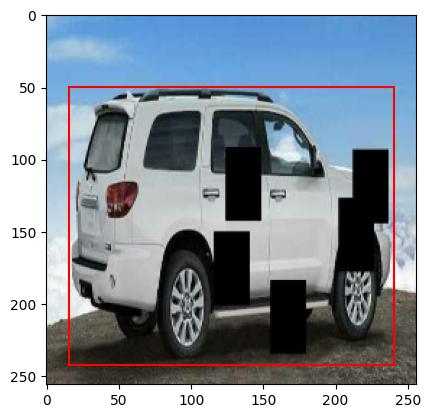

In [123]:
# Array de l'image
im = load_image(df.im_name[8])
# Coordonnées de la bounding box
bbox = df[['xmoy', 'ymoy', 'w', 'h']].values[8]
# Afficher l'image ainsi que la bounding box
show_bounding_box(im, bbox, normalised=False)


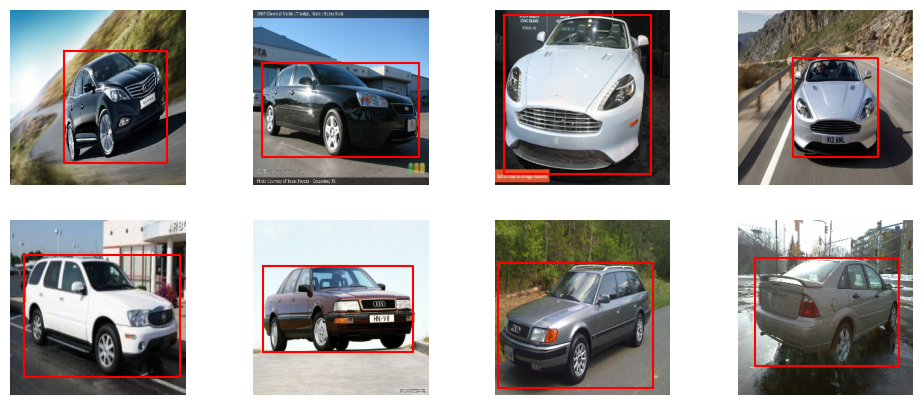

In [124]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
for j, i in enumerate(np.random.randint(0, len(df), size=[8])):
    plt.subplot(2,4,j+1)
    plt.axis('off')
    im = load_image(df.im_name[i])
    bbox = df[['xmoy', 'ymoy', 'w', 'h']].values[i]
    show_bounding_box(im, bbox, normalised=False)


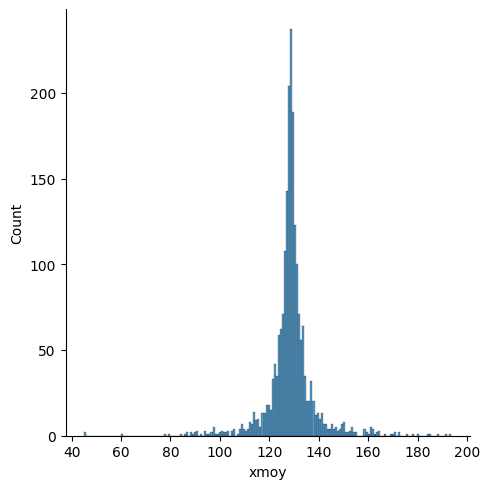

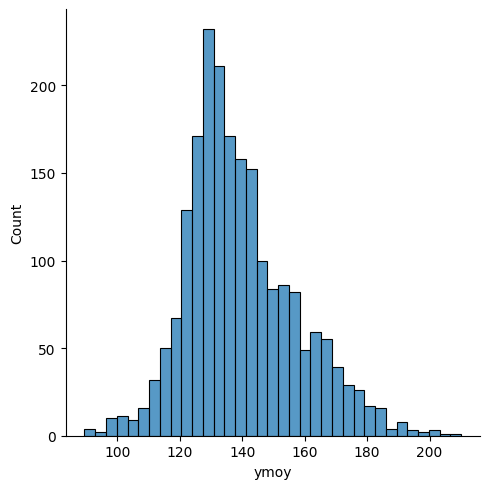

In [125]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.displot(df.xmoy)
plt.show()
sns.displot(df.ymoy)
plt.show()
## La bounding box se trouve généralement au centre de l'image.


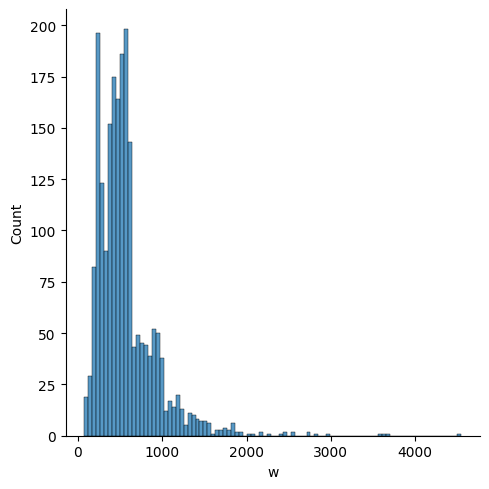

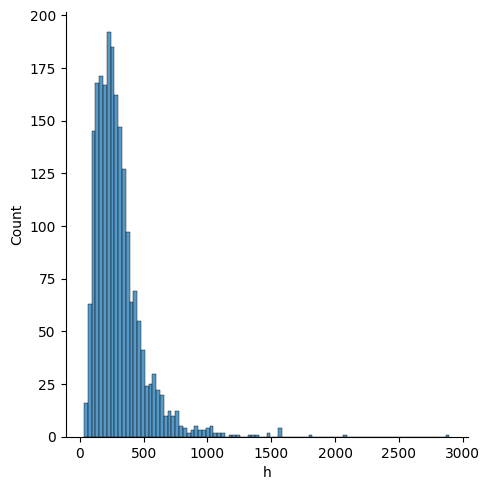

In [9]:
sns.displot(df.w)
plt.show()
sns.displot(df.h)
plt.show()
## Les objets ont généralement la même taille et les petits objets ne sont pas beaucoup représentés.


In [126]:
from sklearn.model_selection import train_test_split
from tqdm import tqdm

X_train_path, X_test_path, y_train, y_test = train_test_split(df.im_name, df[['xmoy', 'ymoy', 'w', 'h']], train_size=0.8, random_state=1234)

X_test = []
for p in tqdm(X_test_path):
    im = load_image(p, (256,256)).numpy().astype(np.uint8)
    X_test.append(im)

X_test = np.array(X_test)


100%|██████████| 418/418 [00:02<00:00, 147.18it/s]


In [127]:
import tensorflow as tf

@tf.function
def load_image(filepath, resize=(256,256)):
    im = tf.io.read_file(folder_images+filepath)
    im = tf.image.decode_png(im, channels=3)
    return tf.image.resize(im, resize)

dataset_train = tf.data.Dataset.from_tensor_slices((X_train_path, y_train))

dataset_train = dataset_train.map(lambda x, y : [load_image(x), y], num_parallel_calls=-1).batch(32)


In [168]:
dataset_test = tf.data.Dataset.from_tensor_slices((X_test_path, y_test))

dataset_test = dataset_test.map(lambda x, y : [load_image(x), y], num_parallel_calls=-1).batch(32)

### Yolo

In [171]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, LeakyReLU, Dropout, Reshape, BatchNormalization
from tensorflow.keras import Sequential

nb_class = 0

# Backbone
efficientNet = EfficientNetB0(include_top=False, input_shape=(256,256,3))

# Freeze the blackbone
for layer in efficientNet.layers:
    layer.trainable = False

# Définition de la partie encoder
model = Sequential()
# Feature extration part
model.add(efficientNet)
model.add(Reshape([-1, 1280]))
# Regression Part
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(5 + nb_class))
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 8, 8, 1280)        4049571   
 )                                                               
                                                                 
 reshape_1 (Reshape)         (None, 64, 1280)          0         
                                                                 
 dense_26 (Dense)            (None, 64, 1024)          1311744   
                                                                 
 dropout_19 (Dropout)        (None, 64, 1024)          0         
                                                                 
 dense_27 (Dense)            (None, 64, 512)           524800    
                                                                 
 dropout_20 (Dropout)        (None, 64, 512)           0         
                                                      

In [172]:
def transform_netout(y_pred_raw):
    y_pred_xy = (tf.nn.tanh(y_pred_raw[..., 1:3]))
    y_pred_wh = tf.sigmoid(y_pred_raw[..., 3:5])
    y_pred_conf = tf.sigmoid(y_pred_raw[..., :1])
    return tf.concat([y_pred_conf, y_pred_xy, y_pred_wh], -1)

In [173]:
df.head()

,im_name,x_min,y_min,x_max,y_max,class,models,xmoy,ymoy,w,h
0,1000407040.jpg,7.0,26.0,392.0,225.0,1,Toyota Sequoia SUV 2012,127.680000,128.512000,246.400000,203.776000
1,1000472576.jpg,27.0,62.0,519.0,298.0,1,Toyota Sequoia SUV 2012,121.544348,142.222222,219.046957,186.469136
2,1000669184.jpg,6.0,62.0,499.0,286.0,1,Toyota Sequoia SUV 2012,129.280000,141.409524,252.416000,182.044444
3,1000800256.jpg,68.0,16.0,450.0,222.0,1,Toyota Sequoia SUV 2012,132.608000,129.084746,195.584000,223.457627
4,1001324544.jpg,33.0,56.0,408.0,294.0,1,Toyota Sequoia SUV 2012,117.600000,124.444444,200.000000,169.244444


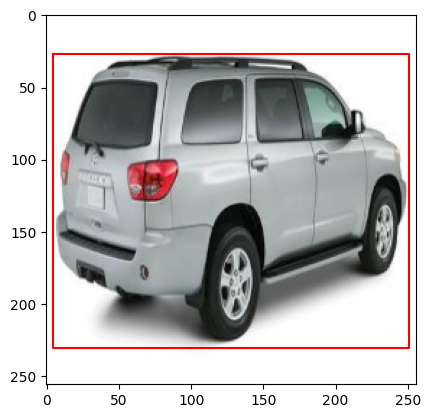

In [176]:
import matplotlib.pyplot as plt
import tensorflow as tf
folder_images = 'train/'

@tf.function
def load_image(filepath, resize=target_size):
    im = tf.io.read_file(folder_images + filepath)
    im = tf.image.decode_png(im, channels=3)
    if resize:
        return tf.image.resize(im, resize)
    else :
        return im


def show_bounding_box(im, bbox, normalised=False, color='r'):
    # Signification de bbox
    x, y, w, h = bbox
    # Convertir les cordonées (x,y,w,h) en (x1,x2,y1,y2)
    x1=x-w/2
    x2=x+w/2
    y1=y-h/2
    y2=y+h/2

    # redimensionner en cas de normalisation
    if normalised:
        x1=x1*im.shape[1]
        x2=x2*im.shape[1]
        y1=y1*im.shape[0]
        y2=y2*im.shape[0]

    # Afficher l'image
    plt.imshow(im)

    # Afficher la bounding box
    plt.plot([x1,x2,x2,x1,x1],[y1,y1,y2,y2,y1],"r")

im = load_image(df.im_name[0])

bbox = df[['xmoy', 'ymoy', 'w', 'h']].values[0]
# Afficher l'image ainsi que la bounding box
show_bounding_box(im/255, bbox)

In [186]:
import tensorflow as tf
import numpy as np


@tf.function
def load_image(filepath, resize=(256,256)):
    im = tf.io.read_file(folder_images+filepath)
    im = tf.image.decode_png(im, channels=3)
    return tf.image.resize(im, resize)

dataset_train = tf.data.Dataset.from_tensor_slices((X_train_path, y_train))

dataset_train = dataset_train.map(lambda x, y : [load_image(x), y], num_parallel_calls=-1).batch(32)

In [195]:
nb_class = 0

def class_loss(y_true, y_pred):
    # Vecteur de présence d'un objet
    y_true_conf = y_true[...,0]
    # Probabilité conditionelle des vrais objets
    y_true_class = tf.one_hot(y_true[...,5], nb_class)
    # Probabilité conditionelle des prédictions
    y_pred_class = y_pred[...,5:]
    # Calcul de la fonction de perte
    class_loss = tf.reduce_sum(y_true_conf*tf.reduce_sum(tf.squarre(y_true_class - y_pred_class), axis=-1), axis=-1)
    return class_loss

def coord_loss(y_true, y_pred):
    # Probabilty of object presence
    y_true_conf = y_true[...,0]

    # x and y loss for real object
    y_true_xy = y_true[...,1:3]
    y_pred_xy = y_pred[...,1:3]
    xy_loss = tf.reduce_sum(tf.reduce_sum(tf.square(y_true_xy - y_pred_xy),axis=-1)*y_true_conf, axis=-1)

    # w and h loss for real object
    y_true_wh = y_true[...,3:5]
    y_pred_wh = y_pred[...,3:5]
    wh_loss = tf.reduce_sum(tf.reduce_sum(tf.square(tf.sqrt(y_true_wh) - tf.sqrt(y_pred_wh)), axis=-1)*y_true_conf, axis=-1)
    return xy_loss + wh_loss

def transform_netout(y_pred_raw):
    y_pred_xy = (tf.nn.tanh(y_pred_raw[..., 1:3]))
    y_pred_wh = tf.sigmoid(y_pred_raw[..., 3:5])
    y_pred_conf = tf.sigmoid(y_pred_raw[..., :1])
    return tf.concat([y_pred_conf, y_pred_xy, y_pred_wh], -1)

lambda_noobj = 0.5

def object_loss(y_true, y_pred):
    # x and y loss for real object
    y_true_p = y_true[...,0]
    y_pred_p = y_pred[...,0]
    return tf.reduce_sum((lambda_noobj + (1-lambda_noobj)*y_true_p)*tf.square(y_true_p - y_pred_p), axis=-1)

lambda_coord = 5
lambda_object = 1

def global_loss(y_true, y_pred):
    # Convert input
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_pred = transform_netout(y_pred)
    loss_coordinate = coord_loss(y_true, y_pred)
    loss_object = object_loss(y_true, y_pred)
    return lambda_object*loss_object + lambda_coord*loss_coordinate



In [196]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import callbacks

model.compile(optimizer=Adam(1e-3), loss=global_loss)




# Save automatically the weights
checkpoint = callbacks.ModelCheckpoint(filepath = 'model',
                                       monitor = 'loss',
                                       save_best_only = True,
                                       save_weights_only = True,
                                       mode = 'min',
                                       save_freq = 'epoch')

# Callback to reduce automatically the learning rate.
lr_plateau = callbacks.ReduceLROnPlateau(monitor = 'loss',
                                         patience=5,
                                         factor=0.1,
                                         verbose=2,
                                         mode='min')

model.fit(dataset_train, epochs=10)

Epoch 1/10


InvalidArgumentError: ignored

### Xception

In [154]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Lambda
from tensorflow.keras.models import Sequential

# Load the Xception model
xception = Xception(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze the Xception backbone
for layer in xception.layers:
    layer.trainable = False

# Create your new model with Xception as the backbone
model = Sequential()
model.add(xception)
model.add(GlobalAveragePooling2D())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(4, activation='linear'))

model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 global_average_pooling2d_5  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_17 (Dense)            (None, 1024)              2098176   
                                                                 
 dropout_12 (Dropout)        (None, 1024)              0         
                                                                 
 dense_18 (Dense)            (None, 512)               524800    
                                                                 
 dropout_13 (Dropout)        (None, 512)               0         
                                                      

In [155]:
from tensorflow.keras.optimizers import SGD, Adam, RMSprop

lambda_regression=10

def loss_function(y_true, y_pred):
    return lambda_regression*tf.reduce_mean(tf.square(y_true-y_pred), axis=-1)

# def loss_function(y_true, y_pred):
#     return lambda_coord*tf.reduce_mean(tf.square(y_true[...,:2]-y_pred[...,:2]), axis=-1) + lambda_largeur*tf.reduce_mean(tf.square(y_true[...,2:4]-y_pred[...,2:4]), axis=-1)


model.compile(loss=loss_function, optimizer=Adam(1e-3))


In [156]:
model.fit(dataset_train, epochs=20)


Epoch 1/20
53/53 [==============================] - 12s 148ms/step - loss: 48359.3008
Epoch 2/20
53/53 [==============================] - 8s 158ms/step - loss: 22856.9258
Epoch 3/20
53/53 [==============================] - 8s 143ms/step - loss: 19792.1719
Epoch 4/20
53/53 [==============================] - 8s 157ms/step - loss: 18243.0039
Epoch 5/20
53/53 [==============================] - 9s 159ms/step - loss: 16517.1641
Epoch 6/20
53/53 [==============================] - 8s 144ms/step - loss: 16343.8604
Epoch 7/20
53/53 [==============================] - 8s 159ms/step - loss: 16687.7070
Epoch 8/20
53/53 [==============================] - 8s 146ms/step - loss: 18732.5352
Epoch 9/20
53/53 [==============================] - 8s 146ms/step - loss: 15220.9600
Epoch 10/20
53/53 [==============================] - 9s 162ms/step - loss: 14435.7920
Epoch 11/20
53/53 [==============================] - 8s 147ms/step - loss: 15343.0840
Epoch 12/20
53/53 [==============================] - 8s 158ms/

1/1 [==============================] - 0s 102ms/step
124.54164 147.91151 181.65335 116.640625
Execution time : 0.23271393775939941 secondes


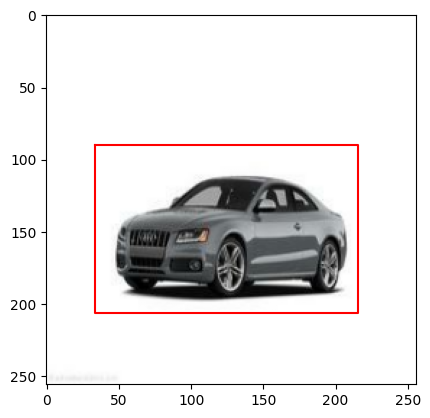

In [162]:
import time
def show_img(img, model):
    plt.imshow(img)
    t0=time.time()
    x, y, w, h = model.predict(np.array([img], dtype=np.float32))[0]
    print(x, y, w, h)
    print("Execution time :",time.time()-t0,"secondes")
    show_bounding_box(img, [x,y,w,h])
    plt.show()

## Exemple :
show_img(X_test[0], model)


### EfficientNETB0

In [197]:
from tensorflow.keras.applications import EfficientNetB0

# Load the model efficientNet
efficientNet = EfficientNetB0(include_top=False, input_shape=(256,256,3))

# Freeze the blackbone
for layer in efficientNet.layers:
    layer.trainable = False


In [198]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D, MaxPooling2D, BatchNormalization, LeakyReLU, Flatten
from tensorflow.keras.models import Model, Sequential, load_model

model = Sequential()
model.add(efficientNet)
model.add(GlobalAveragePooling2D())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(4, activation='linear'))
model.summary()


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 8, 8, 1280)        4049571   
 )                                                               
                                                                 
 global_average_pooling2d_6  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_30 (Dense)            (None, 1024)              1311744   
                                                                 
 dropout_22 (Dropout)        (None, 1024)              0         
                                                                 
 dense_31 (Dense)            (None, 512)               524800    
                                                                 
 dropout_23 (Dropout)        (None, 512)              

In [199]:
from tensorflow.keras.optimizers import SGD, Adam, RMSprop

lambda_regression=10

def loss_function(y_true, y_pred):
    return lambda_regression*tf.reduce_mean(tf.square(y_true-y_pred), axis=-1)

# def loss_function(y_true, y_pred):
#     return lambda_coord*tf.reduce_mean(tf.square(y_true[...,:2]-y_pred[...,:2]), axis=-1) + lambda_largeur*tf.reduce_mean(tf.square(y_true[...,2:4]-y_pred[...,2:4]), axis=-1)


model.compile(loss=loss_function, optimizer=Adam(1e-3))


In [ ]:
iterator = iter(dataset_train)

# Define the number of batches you want to visualize
num_batches_to_visualize = 5

for batch in range(num_batches_to_visualize):
    # Get the next batch of data
    data_batch = next(iterator)
    if batch==4:
      for i in range(32):
      # Assuming each batch contains features and labels, you can access them as follows:
        features = data_batch[0][i]

        # Visualize the data in this batch, for example, you can display the first image in the batch
        plt.figure()
        plt.imshow(features.numpy()/255.0)  # Assuming the features are images
        plt.title(f'Image {i+1} du batch 4')
        plt.show()

In [203]:
# Save automatically the weights
checkpoint = callbacks.ModelCheckpoint(filepath = 'model',
                                       monitor = 'loss',
                                       save_best_only = True,
                                       save_weights_only = True,
                                       mode = 'min',
                                       save_freq = 'epoch')

# Callback to reduce automatically the learning rate.
lr_plateau = callbacks.ReduceLROnPlateau(monitor = 'loss',
                                         patience=5,
                                         factor=0.1,
                                         verbose=2,
                                         mode='min')

history = model.fit(dataset_train, epochs=30, validation_data=dataset_test, callbacks=[checkpoint, lr_plateau])


Epoch 1/30
53/53 [==============================] - 19s 356ms/step - loss: 7157.6201 - val_loss: 4914.4482 - lr: 0.0010
Epoch 2/30
53/53 [==============================] - 8s 152ms/step - loss: 5395.5200 - val_loss: 3821.6675 - lr: 0.0010
Epoch 3/30
53/53 [==============================] - 10s 193ms/step - loss: 4365.4204 - val_loss: 3518.8884 - lr: 0.0010
Epoch 4/30
53/53 [==============================] - 11s 201ms/step - loss: 3918.8403 - val_loss: 3111.1707 - lr: 0.0010
Epoch 5/30
53/53 [==============================] - 8s 149ms/step - loss: 3661.4014 - val_loss: 3559.7673 - lr: 0.0010
Epoch 6/30
53/53 [==============================] - 9s 178ms/step - loss: 3422.6348 - val_loss: 2957.1133 - lr: 0.0010
Epoch 7/30
53/53 [==============================] - 9s 178ms/step - loss: 3198.6880 - val_loss: 2756.9041 - lr: 0.0010
Epoch 8/30
53/53 [==============================] - 8s 151ms/step - loss: 2961.1433 - val_loss: 2754.7847 - lr: 0.0010
Epoch 9/30
53/53 [===========================

1/1 [==============================] - 0s 70ms/step


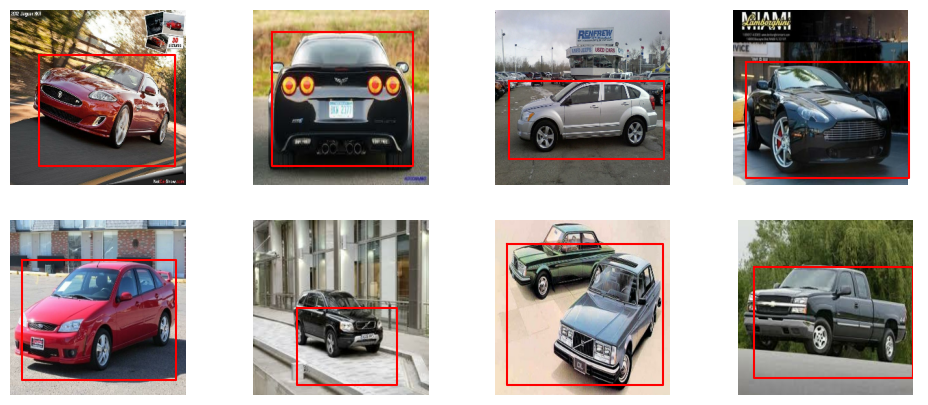

In [213]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
for j, i in enumerate(np.random.randint(0, 418, size=[8])):
    plt.subplot(2,4,j+1)
    plt.axis('off')
    im = X_test[i]
    x, y, w, h = model.predict(np.array([im], dtype=np.float32))[0]
    bbox = df[['xmoy', 'ymoy', 'w', 'h']].values[i]
    show_bounding_box(im, [x,y,w,h])
